# Bootstrapping

<div>
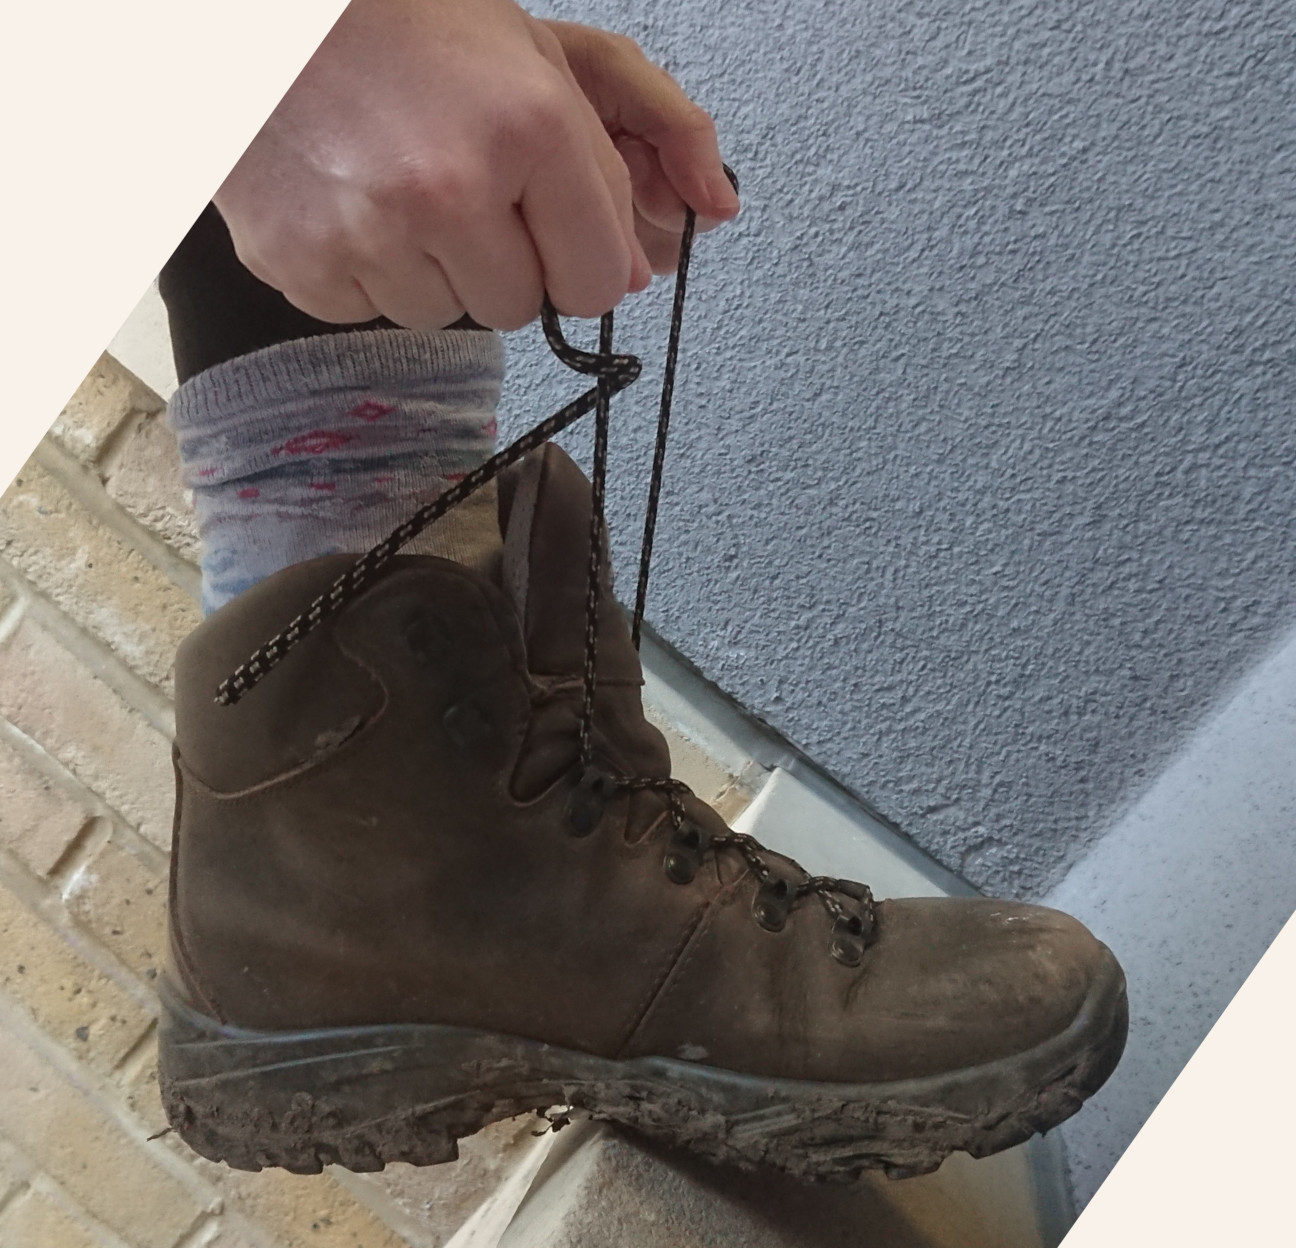
</div>

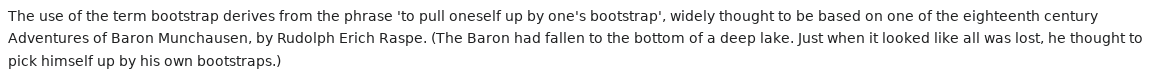
\- An Introduction to the bootstrap, Efron and Tibshirani, 1994


# Statistic uncertainty
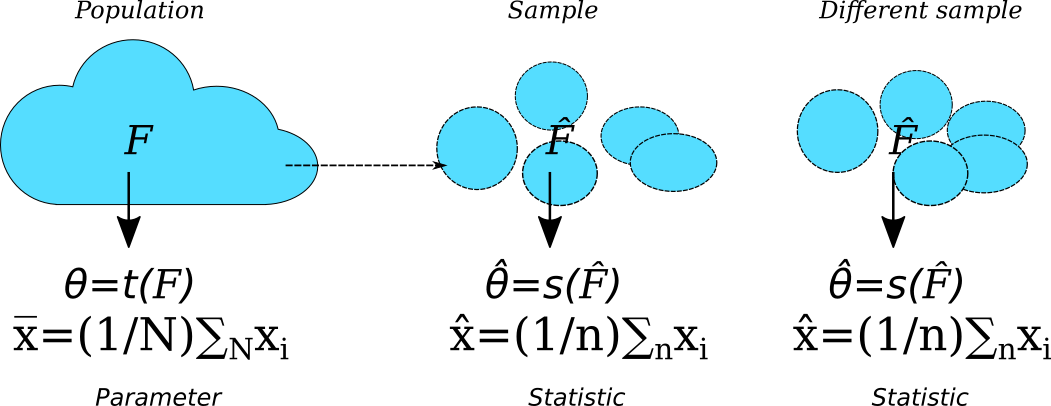

# Plug in estimates
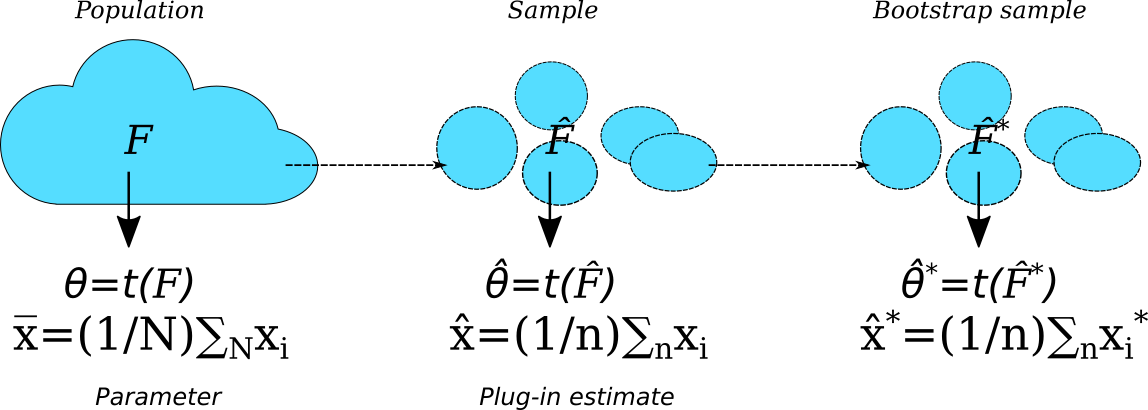
* parameters as functions of population
* statistics as estimates of parameters from samples
* plug-in estimate: estimating statistic by using sample as if it was population; for example mean and uncorrected variance. Often histogram implicitly assumed to represent population.
* standard error: the standard deviation on a statistic estimated from the population using a given sample size
* bootstrapping: estimating standard error (and other uncertainties) by plug-in estimation from the sample: pretend the sample is the population, sample with replacement.
* Looks a bit like permutation testing, but different approach (sampling with replacement versus randomly exchanging data) and aims (estimating uncertainty of estimates, versus testing null hypothesis).

# Demo with TIV dataset

This is a dataset of total intracranial volume (/ml) measures on scans, each observation is an image. We are interested in three columns: `man` are manual measures of TIV, `spm12_mwc` and `fs5` are automated measures. The manual measures have been found to be quite accurate, we would like to evaluate the more variable automated measures against them. We could compare means and coefficients of regression, but as this is often used as a nuisance covariate, the $R^2$ value indicating how much of the variance is retained is particularly of interest.

In [1]:
suppressPackageStartupMessages({
    library(foreign) # reading stata dataset
    library(dplyr)# table manipulation
    })
# read the TIV data
mydata <- read.dta("comparison_TIV_all_resp_2.dta")
mydata <- filter(mydata,!is.na(man)) %>% select(man,fs5,spm12_mwc)
head(mydata)

,man,fs5,spm12_mwc
,<dbl>,<dbl>,<dbl>
3,1345.541,1497.891,1353.598
4,1381.081,1436.819,1359.308
5,1285.623,1268.764,1265.084
6,1574.595,1680.504,1557.601
7,1182.910,1172.865,1170.121
8,1408.842,1500.151,1391.574


## Regression model
Just getting regression coefficients and $R^2$ from a linear regression model for the two sets of values:

In [2]:
model.mwc <- lm(spm12_mwc~man,mydata) # linear model
print(model.mwc)
sprintf("Rsquared=%f",summary(model.mwc)$r.squared) # Don't want all of summary
model.fs5 <- lm(fs5~man, mydata)
print(model.fs5)
sprintf("Rsquared=%f",summary(model.fs5)$r.squared)


Call:
lm(formula = spm12_mwc ~ man, data = mydata)

Coefficients:
(Intercept)          man  
     1.5103       0.9707  



[1] "Rsquared=0.940316"


Call:
lm(formula = fs5 ~ man, data = mydata)

Coefficients:
(Intercept)          man  
   -345.260        1.289  



[1] "Rsquared=0.460257"

## Defining our bootstrap statistic
The values are quite different, but how good is our estimate of that difference? This is where the bootstrap is useful. The `boot` function will do most of the work, but we need to define the statistic we want to bootstrap.

In [3]:
library(boot) # Library for bootstrapping functions, investigate ?boot

# required arguments of boot: function (data, statistic, R)
# data : data frame to sample from
# statistic : function that calculates the statistic or statistics to bootstrap
# R : number of repetitions

# Step 1: define a function that returns our statistic of interest:
# the difference in R values. It will take a data frame and sampling
# indices:
diffR2 <- function(thisdata, set){
    model.mwc <- lm(spm12_mwc~man,thisdata[set,])
    model.fs5 <- lm(fs5~man, thisdata[set,])
    # By default R functions return the last value:
    summary(model.mwc)$r.squared - summary(model.fs5)$r.squared
}

## Running the bootstrap
At a minimum we have to supply the data, a function to calculate our statistic (or statistics) and the number of repetitions:

In [4]:
# Step 2: try bootstrapping it, will take a few seconds
bootstrap.diffR2.1000 <- boot(mydata, diffR2, 1000)

In [5]:
# Just printing it will give the estimate (from original sample)
# and bootstrap standard error and bias estimates
bootstrap.diffR2.1000


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = diffR2, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.4800598 -0.06479113   0.1304204

## Checking bootstrap outputs

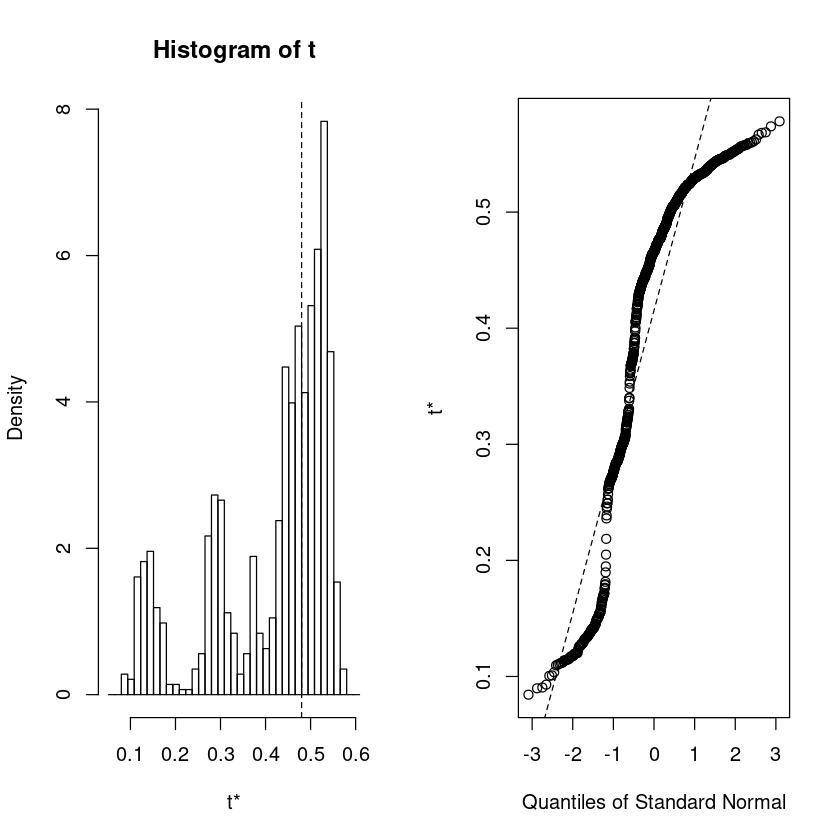

In [6]:
plot(bootstrap.diffR2.1000)

This shows the distribution of our statistic across bootstrap samples. That distribution looks very unpleasant.

The bootstrap is quite good, but should we worry about outliers? Two options:

1. We could use a more robust statistic. The ability to estimate standard error on the median rather than the mean is often used to demonstrate the bootstrap, but we really want to investigate R^2.
2. What we should have done at the start; look at the data!

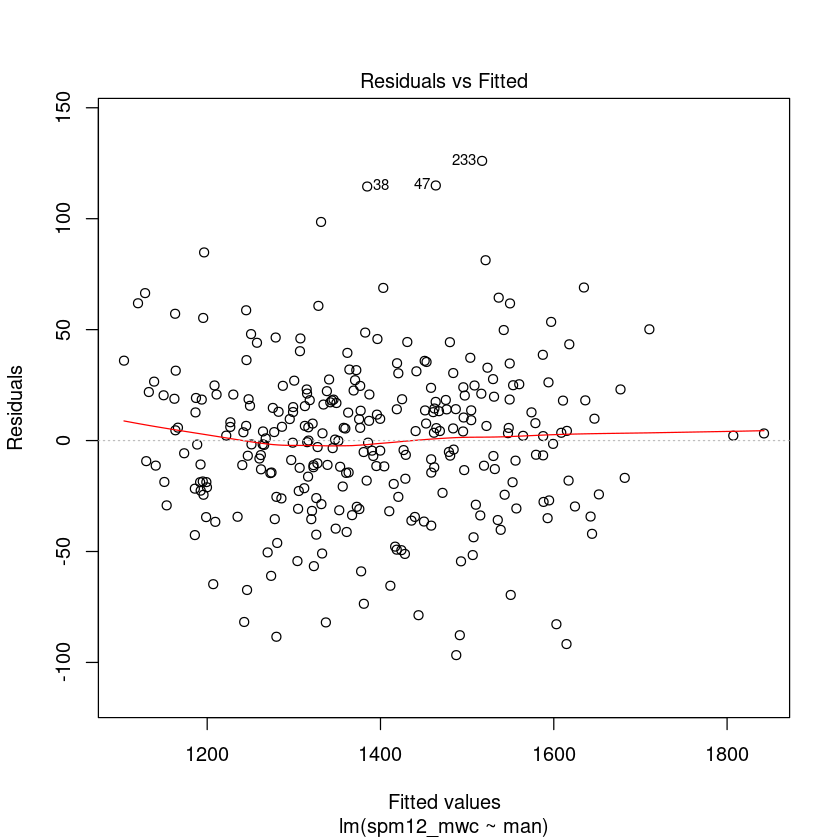

In [7]:
plot(model.mwc,which=1)

Not too bad...

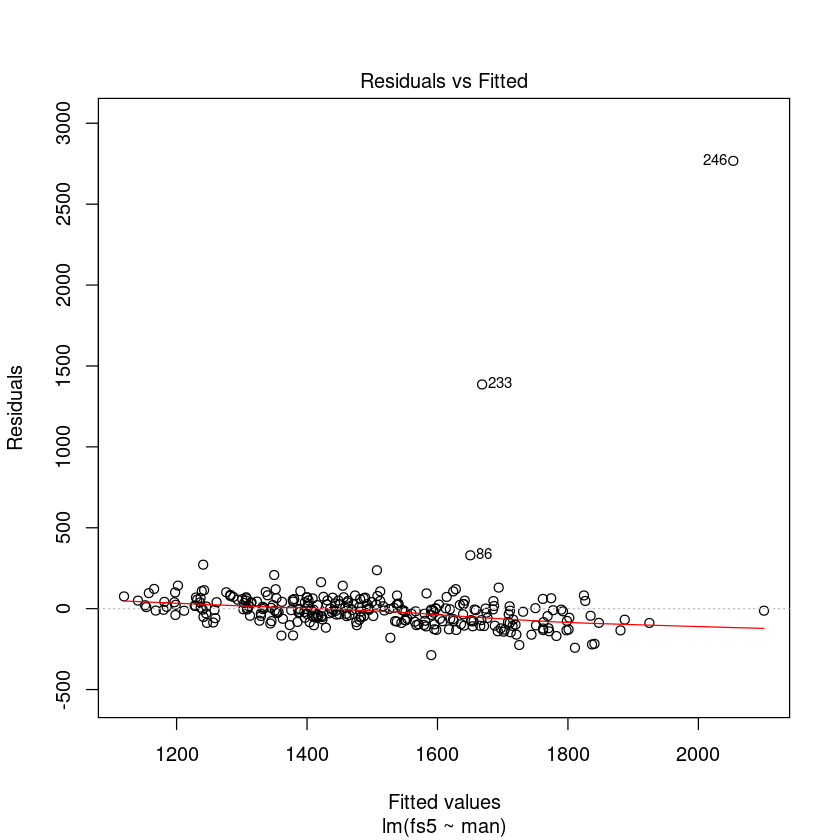

In [8]:
plot(model.fs5,which=1)

Ah... These two fs5 TIV (rows 209, 221) were estimated at >3000ml. QC showed they were misregistrations. Let's get rid of them.

In [9]:
mycleandata <- filter(mydata, fs5<3000)
bootstrap.diffR2.1000.clean <- boot(mycleandata, diffR2, 1000)

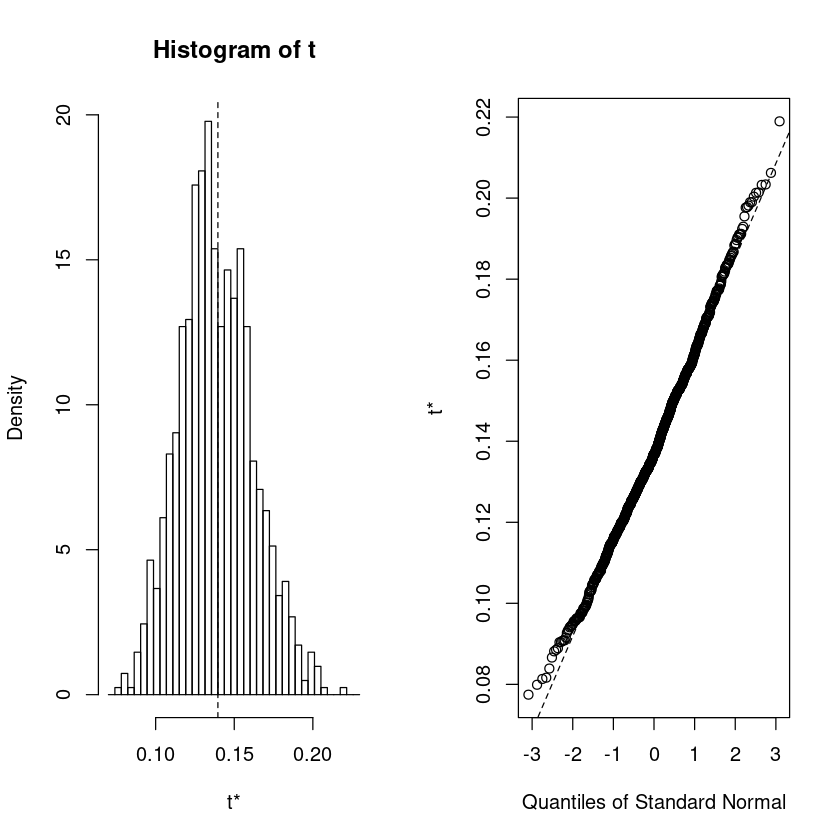

In [10]:
plot(bootstrap.diffR2.1000.clean)

Better! And the estimates?

In [11]:
bootstrap.diffR2.1000.clean


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mycleandata, statistic = diffR2, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.1396005 -0.001037682  0.02333421

It'd be nice to be able to see what difference this has made to our estimates, but first we'll have to get the numbers out.

In [12]:
# Bootstrap objects don't contain standard error and estimate, we'll have to calculate them ourselves!
names(bootstrap.diffR2.1000)

[1] "t0"        "t"         "R"         "data"      "seed"      "statistic"
 [7] "sim"       "call"      "stype"     "strata"    "weights"

## Calculating from the bootstrap
The print function for the bootstrap object reports the sample value of the statistic, the bootstrap bias and the standard error. However the object doesn't contain them, so we need to calculate them ourselves if we want to use them later. Fortunately they're trivial. The following function shows how to derive them, and produces a tidier summary that will be useful later.

In [13]:
makesummary <- function(somebootstrap) {
  se.est <- sd(somebootstrap$t) # t is all the sampled statistics
  original <- somebootstrap$t0 # t0 value from original sample
  bias.est <- mean(somebootstrap$t) - original # the mean of bootstraps doesn't necessarily equal sample estimate!
  data.frame(original=original, bias=bias.est, std.err = se.est,
            row.names=substitute(somebootstrap))
    # bit of R-trickery at the end to get the argument name
}
makesummary(bootstrap.diffR2.1000.clean)

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000.clean,0.1396005,-0.001037682,0.02333421


Now we can see the two together:

In [14]:
summary.1000 <- makesummary(bootstrap.diffR2.1000)
summary.1000.clean <- makesummary(bootstrap.diffR2.1000.clean)
rbind(summary.1000,summary.1000.clean)

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.064791128,0.13042037
bootstrap.diffR2.1000.clean,0.1396005,-0.001037682,0.02333421


Big drop in the difference (because $R^2$ for fs5 has increased a lot), but also much smaller bias and standard error of the estimate. Let's try the confidence intervals.

## Confidence intervals

Getting the standard error is the most basic use of the bootstrap, Efron 1994 suggests you can get away with a few hundred iterations for standard error estimates, but ~1000 now generally preferred to reduce the Monte Carlo error.

We could calculate a z-value for the difference now, and use it to calculate a p-value for the difference, but this assumes normality of the statistic samples. Besides, it would be interesting to see the confidence intervals. The two most simple are normal (assumes normality) and percentile (use percentiles from the histogram).

In [15]:
bootstrap.diffR2.1000.simple.ci <- boot.ci(bootstrap.diffR2.1000, type=c("norm","perc"))
bootstrap.diffR2.1000.simple.ci

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.1000, type = c("norm", "perc"))

Intervals : 
Level      Normal             Percentile     
95%   ( 0.2892,  0.8005 )   ( 0.1194,  0.5518 )  
Calculations and Intervals on Original Scale

It's important to note that `R=1000` is not really enough for accurate confidence intervals, we'll get to that shortly.

## Accessing confidence intervals
We might want to get at those confidence interval values, if we've assigned the `boot.ci` result to an object then they're stored in the corresponding names:

In [16]:
names(bootstrap.diffR2.1000.simple.ci)

[1] "R"       "t0"      "call"    "normal"  "percent"

Although how they're stored is a little inconsistent:

In [17]:
bootstrap.diffR2.1000.simple.ci$normal
bootstrap.diffR2.1000.simple.ci$percent

conf,,
0.95,0.2892317,0.8004701


conf,,,,
0.95,25.03,975.98,0.1194219,0.5518485


For Normal, we just have the confidence level (95%) and the confidence intervals (`[2:3]`), for the others there are extra elements relating to the percentile locations, confidence intervals still come at the end (`[4:5]`)

There are three other approaches:
1. Basic is similar to percentile, it has a logical basis, but produces poor results.
2. Studentized is a bit more complicated to apply (we need standard error estimates from each bootstrap sample), builds a t-distribution for the data and then uses percentiles.
3. Bias-corrected-accelerated (BCa), this takes some additional calculation and, by default, quite a lot of memory (it needs to store R * sample size elements), but is the most generally applicable and requires least worrying. 

Using 'boot.ci' without type attempts to calculate them all:

In [18]:
bootstrap.diffR2.1000.clean.ci <- boot.ci(bootstrap.diffR2.1000.clean)
bootstrap.diffR2.1000.clean.ci

Warning message in boot.ci(bootstrap.diffR2.1000.clean):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.1000.clean)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0949,  0.1864 )   ( 0.0924,  0.1836 )  

Level     Percentile            BCa          
95%   ( 0.0956,  0.1868 )   ( 0.1009,  0.1986 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

We can see all the intervals find an interval for $R^2$ well away from 0.

**Given the choice the BCa is the one to use.** (or see ABC in the bonus section) But there's one more thing to fix...

## Number of replications and parallelism
While 1000 iterations would be fine for a standard error estimate, it's a bit too low for a confidence interval estimate (we need more in the tails). **About 10000 should be enough**, but it will take my computer a while. Fortunately bootstrapping is very parallel-processing friendly.

In [19]:
bootstrap.diffR2.10000.clean <- boot(mycleandata, diffR2, 10000, parallel="multicore", ncpus=4)

In [20]:
summary.10000.clean <- makesummary(bootstrap.diffR2.10000.clean)
summary.all3 <- rbind(summary.1000, summary.1000.clean, summary.10000.clean)
summary.all3

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.0647911277,0.13042037
bootstrap.diffR2.1000.clean,0.1396005,-0.0010376824,0.02333421
bootstrap.diffR2.10000.clean,0.1396005,-0.0003964556,0.02322026


Standard error is not much changed from 1000 to 10000 iterations, but the bias estimate is quite variable between bootstraps.

In [21]:
bootstrap.diffR2.10000.clean.ci <- boot.ci(bootstrap.diffR2.10000.clean)
bootstrap.diffR2.10000.clean.ci

Warning message in boot.ci(bootstrap.diffR2.10000.clean):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.10000.clean)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0945,  0.1855 )   ( 0.0914,  0.1826 )  

Level     Percentile            BCa          
95%   ( 0.0966,  0.1878 )   ( 0.1018,  0.1956 )  
Calculations and Intervals on Original Scale

### Comparison of replicate regression and jacknife estimation for BCa
For large sample sizes, the default approach used to calculate BCa can be very slow and require a lot of memory. It uses a method that operates on a $samples * bootstraps$ matrix.

In [22]:
system.time(ci.reg <- boot.ci(bootstrap.diffR2.10000.clean,type="bca"))

   user  system elapsed 
  1.869   0.062   1.954 

In this case you can use a different method to provide the influence estimates the BCa requires, this is done with the empinf function. Its default is the regression method (`reg`), but `jack` (Jacknife) can be more efficient for large samples. (There is also `inf` infinitessimal Jacknife if you are using a weighted bootstrap.)

In [23]:
system.time(ci.jack <- boot.ci(bootstrap.diffR2.10000.clean,type="bca",L=empinf(bootstrap.diffR2.10000.clean,type="jack")))

   user  system elapsed 
  0.617   0.000   0.620 

In [24]:
ci.reg$bca
ci.jack$bca

conf,,,,
0.95,438.73,9878.28,0.1017888,0.195637


conf,,,,
0.95,441.28,9879.59,0.101839,0.1957536


Producing very similar values. While the time difference is small here, large samples can be more of a problem. The default (`reg`) requires matrix manipulation of a $samples * bootstraps$ matrix, which can be very big, but doesn't require `statistic()` to be evaluated again. `jack` needs far less memory, but has to run `statistic()` another $samples$ times. (Bootstrap methods and their application, 2.7.3, 2.7.4 doi:10.1017/CBO9780511802843.003)

The published 95% BCa interval for this data is [0.101, 0.194] (using Stata). Unless there's good reason to do otherwise, the BCa interval is the one you should use, although note that BCa estimates become less stable for low $\alpha$ tails, below 0.025.

## P-values
Speaking of Stata... if you use Stata you will also get z-values and p-values alongside your confidence intervals. These appear to be calculated from the standard error under normality assumption; z as the ratio of statistic to standard error, p as the two-sided tails of the Normal distribution on z.

Here's what Stata is probably doing:

In [25]:
summary.all3$z <- summary.all3$original / summary.all3$std.err
summary.all3$p <- 2 * (1-pnorm(abs(summary.all3$z)))
summary.all3

,original,bias,std.err,z,p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.0647911277,0.13042037,3.680865,2.324442e-04
bootstrap.diffR2.1000.clean,0.1396005,-0.0010376824,0.02333421,5.982653,2.195328e-09
bootstrap.diffR2.10000.clean,0.1396005,-0.0003964556,0.02322026,6.012013,1.832334e-09


You could alternatively try to use the bootstrap distribution tails for this, although to do it correctly you need to set up the bootstrap to simulate your null hypothesis. The bootstrap can be applied more generally, but doesn't have the asymptotically exact behaviour of permutation testing. We could permutation test too of course (in this case), although in marginal cases it may not agree perfectly with the bootstrap intervals.

## Repeatability

Because bootstrapping uses random samples, it will be slightly different every time.

In [26]:
boot1<-boot(mycleandata, diffR2, 1000)
boot2<-boot(mycleandata, diffR2, 1000)
rbind(makesummary(boot1),makesummary(boot2))

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
boot1,0.1396005,0.0001276109,0.02364209
boot2,0.1396005,-0.0002332945,0.02298412


If we need to re-generate the same sampling we can set the random seed.

In [27]:
newseed <- sum(as.integer(charToRaw("2020 is over")))
set.seed(newseed)
boot3<-boot(mycleandata, diffR2, 1000)
set.seed(newseed)
boot4<-boot(mycleandata, diffR2, 1000)
rbind(makesummary(boot3),makesummary(boot4))

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
boot3,0.1396005,-0.0005999831,0.02292003
boot4,0.1396005,-0.0005999831,0.02292003


## Multiple parameters

It's possible to estimate more than one parameter at a time. Let's leave $R^2$ and look at the regression coefficients themselves.

In [28]:
model.mwc$coefficients

(Intercept)         man 
  1.5102840   0.9706556

These are our sample estimates. Of course there's a standard estimate for the se of the regression coefficients.

In [29]:
summary(model.mwc)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.5102840,20.75304366,0.0727741,9.420368e-01
man,0.9706556,0.01446016,67.1262203,4.305247e-177


But can we bootstrap it? We need to define a function, this is simpler than last time, as we just need to report back the model coefficients.

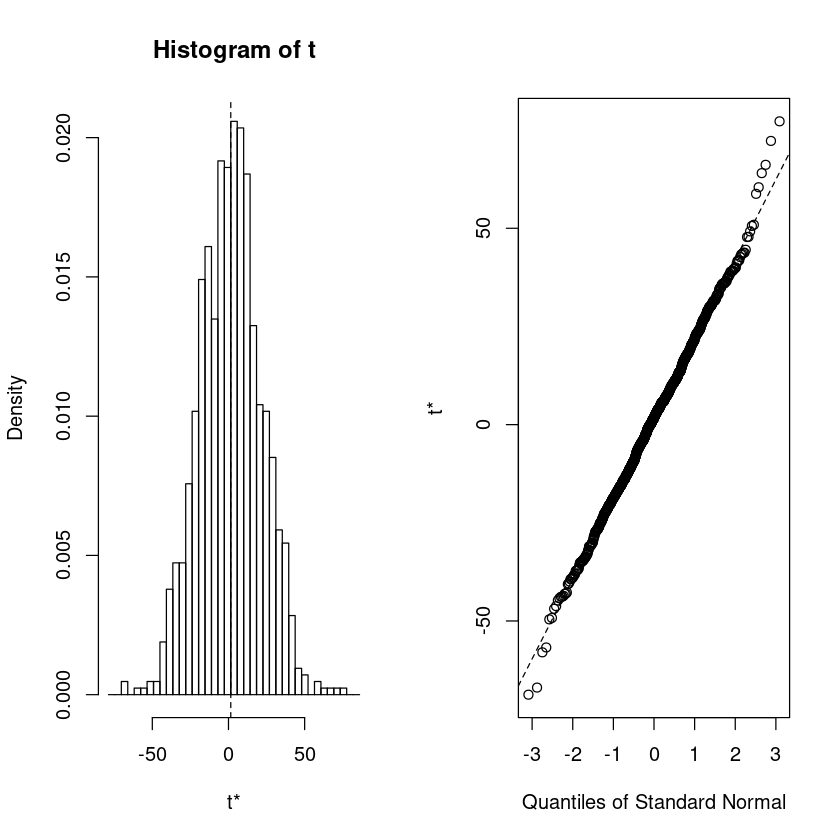

In [30]:
regressCoeffs <- function(thisdata,set){
    thismodel <- lm(spm12_mwc ~ man, thisdata[set,])
    thismodel$coefficients
}
# model.mwc was done without the fs5 outliers removed, so let's stick with that
regress.boot <- boot(mydata, regressCoeffs, 1000)
plot(regress.boot)

Looks fine for the first statistic, what about the other? We need to tell plot which one using `index` (default 1):

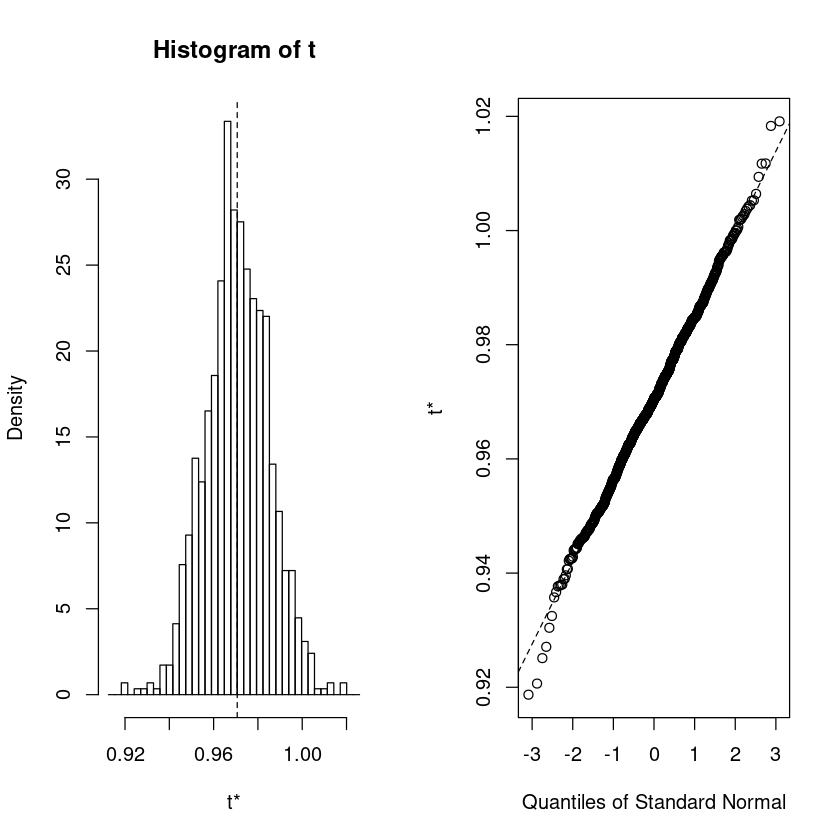

In [31]:
plot(regress.boot,index=2)

In [32]:
regress.boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = regressCoeffs, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 1.5102840 -1.412939e-01 20.34284200
t2* 0.9706556  7.621827e-05  0.01438879

In [33]:
summary(model.mwc)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.5102840,20.75304366,0.0727741,9.420368e-01
man,0.9706556,0.01446016,67.1262203,4.305247e-177


Not bad.

### A warning!

In [34]:
boot.ci(regress.boot,type=c("perc","norm","stud"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = regress.boot, type = c("perc", "norm", "stud"))

Intervals : 
Level      Normal            Studentized          Percentile     
95%   (-38.220,  41.523 )   (-37.135,  40.799 )   (-38.333,  39.621 )  
Calculations and Intervals on Original Scale

We've got studentized intervals now? **No we don't.**

If the statistic function returns two statistics then by default `boot.ci` assumes the second is the standard error estimate for the first. This is convenient if that's what you're doing, otherwise watch out for claimed Studentized intervals that aren't.

## Sampling
There is not necessarily just one way to sample from a population. In the TIV data we had data [$manual_i$, $spm_i$, $fs5_i$], and drew independent samples from these as a joint distribution. However, in a situation where we had chosen the measurement points (say our TIV were simulated volumes which we chose to distribute over a range), then we may not want to sample randomly the independent variables.

In this case we might instead sample from residuals, by first fitting some model: $y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

We can then calculate the residuals $\epsilon_i = y_i - \hat \beta_0 + \hat \beta_1 x_i$ ($\hat\beta_j$ are the estimated values)


And resample from $\epsilon_i$ to $\epsilon_i^*$, then calculate $y_i^* = \hat\beta_0 + \hat\beta_1 x_i + \epsilon_i^*$ and proceed to calculate our statistic on this data.

The only change required is that our function performs a different calculation (and for efficiency we should pre-compute residuals, in fact the model object already has them, ```model.mwc$residuals```). Bootstrapping on residuals is more sensitive to assumptions than bootstrapping on observations.

The rule of thumb is to try to have the bootstrap sampling replicate the data collection.

# More complicated sampling

In the TIV example we are sampling from a single set of observations. This might not always be the case. In the residuals example we already have a slightly more complex example, as the plug-in distribution contains estimates of the $\beta_j$ as well as the observed residuals $\epsilon_i$.

But what if we have two groups? We could have a group variable and sample as if from a single population, however the resulting estimate would include variance in the group membership as well.

What we have to do is identify that our bootstrap sample will be drawn from more than one population.

## Placebo vs control
Say we've got vaccine data, 14000 people on treatment, and 14000 on placebo. After some interval there are 8 infections in the treatment group and 86 in the placebo group. How effective is it? What is the uncertainty on that estimate?

In [35]:
# Risk ratio :
armsize <- 14000
inf.vacc <- 8
inf.plac <- 86
rr <- (inf.vacc/armsize) / (inf.plac/armsize)
effic <- 1-rr
print(paste(100*c(rr, effic)))

[1] "9.30232558139535" "90.6976744186046"


That's to say ~9% of the infection rate in treatment compared to placebo, or ~91% efficacy. As the situation is binomial there's actually an analytical estimate for the uncertainty:

In [36]:
library(fmsb)
rr.est <- riskratio(inf.vacc,inf.plac,armsize,armsize)
rr.est

           Disease Nondisease Total
Exposed          8      13992 14000
Nonexposed      86      13914 14000



	Risk ratio estimate and its significance probability

data:  inf.vacc inf.plac armsize armsize
p-value = 6.661e-16
95 percent confidence interval:
 0.04509461 0.19189269
sample estimates:
[1] 0.09302326


Again, subtract from 1 to convert to efficacy

In [37]:
100*(1-rr.est$conf.int)
rr.est.big.ci <- rev(100*(1-rr.est$conf.int)) # more conventional way around
rr.est.big.ci

[1] 95.49054 80.81073
attr(,"conf.level")
[1] 0.95

[1] 80.81073 95.49054

So, we don't need bootstrapping here. But it would be a useful example to look at group comparisons, however, the very big sample is a problem, it takes longer to create these samples. Fortunately the uncertainty is relatively independent of arm size so long as they're a lot bigger than the case numbers:

In [38]:
smallarm <- 1000
rr.est.small <- riskratio(inf.vacc,inf.plac,smallarm,smallarm)
rr.est.small.ci <- rev(100*(1-rr.est.small$conf.int))
rr.est.small

           Disease Nondisease Total
Exposed          8        992  1000
Nonexposed      86        914  1000



	Risk ratio estimate and its significance probability

data:  inf.vacc inf.plac smallarm smallarm
p-value = 2.22e-16
95 percent confidence interval:
 0.04531807 0.19094648
sample estimates:
[1] 0.09302326


## Create sample data
We create the observations, they're quite simply outcome (no infection/infection) and group membership (placebo/vaccine)

In [39]:
vacctrial <- data.frame(outcome=c(rep(1,inf.plac),rep(0,smallarm-inf.plac),rep(1,inf.vacc),rep(0,smallarm-inf.vacc)), group=c(rep(0,smallarm),rep(1,smallarm)))
table(vacctrial)

       group
outcome   0   1
      0 914 992
      1  86   8

## Define our statistic
This is just the efficacy rate above. This function needs to be run each bootstrap, so it's worth trying to make it efficient.

In [40]:
effrate <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate * 100
 }
effrate(vacctrial)

[1] 90.69767

## Stratified bootstrap time!
Notice we now give the `boot()` function a `strata` argument. This tells it the sample contains different subgroups which should be sampled independently. Each bootstrap sample will take the group0 samples from group 0 and group 1 samples from group 1.

In [41]:
boot.risk.1000 <- boot(vacctrial,effrate, 1000, strata=vacctrial$group)

Notice that both the statistic (effrate) and the bootstrap make use of group. effrate needs it to calculate determine which samples are in which group for its calculation, strata needs it to know how the samples should be divided.

In [42]:
boot.risk.1000


STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrial, statistic = effrate, R = 1000, strata = vacctrial$group)


Bootstrap Statistics :
    original     bias    std. error
t1* 90.69767 -0.1798091    3.540239

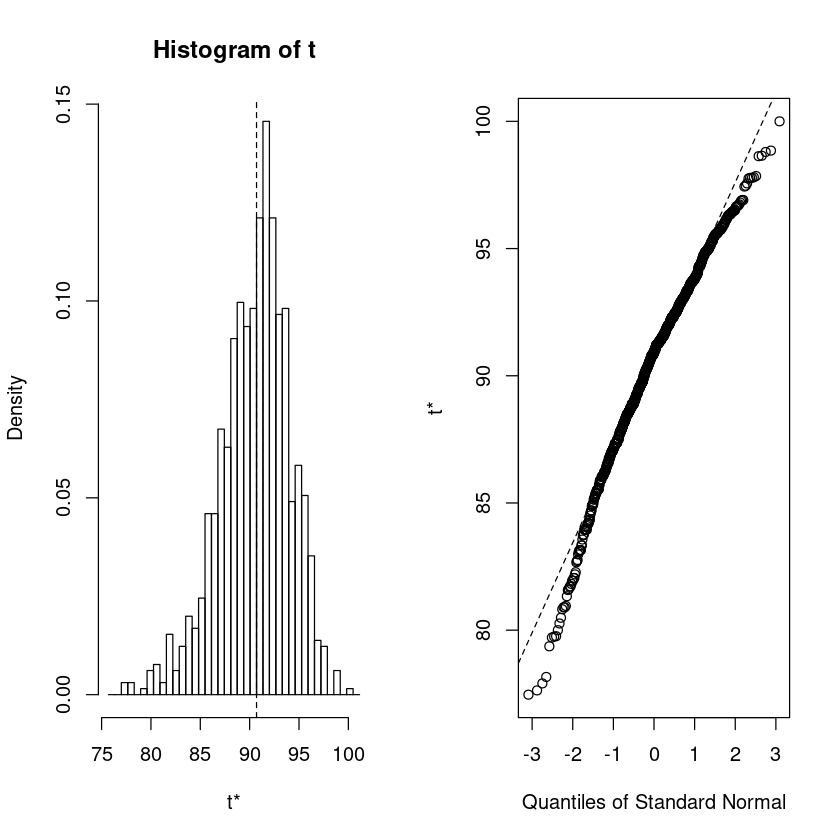

In [43]:
plot(boot.risk.1000)

In [44]:
boot.ci(boot.risk.1000,type=c("norm","basic","perc"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot.risk.1000, type = c("norm", "basic", 
    "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   (83.94, 97.82 )   (84.92, 99.34 )   (82.05, 96.47 )  
Calculations and Intervals on Original Scale

We expected:

In [45]:
rr.est.small.ci

[1] 80.90535 95.46819

The basic bootstrap is badly biassed, the Normal boostrap is also overoptimistic as it doesn\'t handle the skew. The percentile bootstrap is a bit better. Let's try BCa:

In [46]:
try( # catch the error when it doesn't work
    boot.ci(boot.risk.1000,type=c("bca"))
    )

Error in bca.ci(boot.out, conf, index[1L], L = L, t = t.o, t0 = t0.o,  : 
  estimated adjustment 'a' is NA


BCa fails because we don't have enough bootstrap estimates, we actually need more than there are elements in the sample. In any case, we had less replicates than we said were needed for confidence intervals anyway. Let's try again.

In [47]:
boot.risk.10000 <- boot(vacctrial,effrate, 10000, strata=vacctrial$group, parallel = "multicore", ncpus = 4)

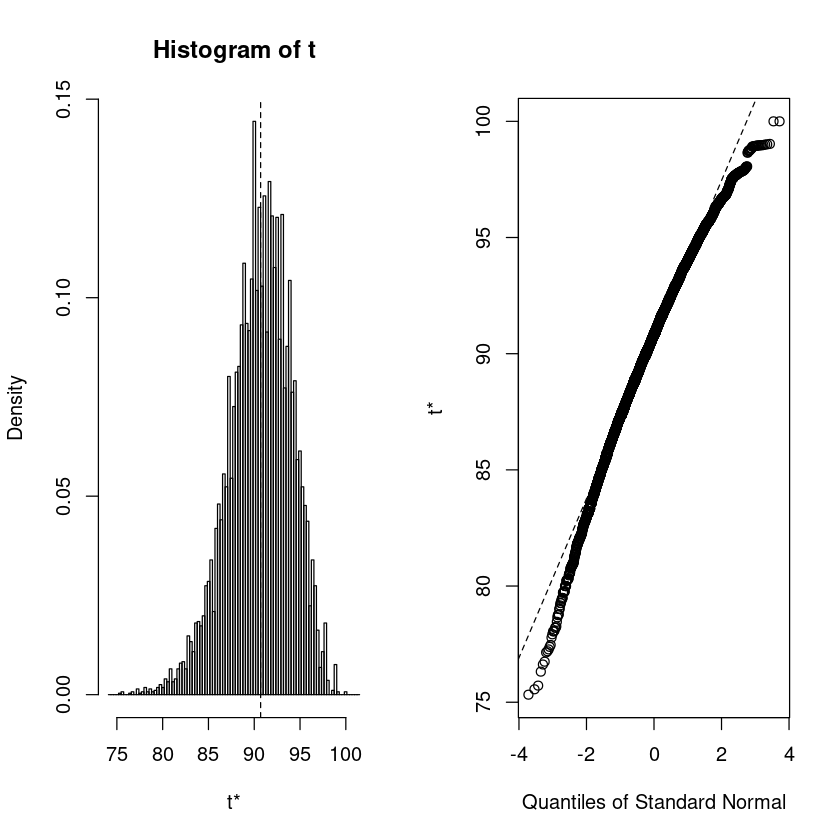

In [48]:
plot(boot.risk.10000)

Skew in the tails is much clearer now. Let's try again, this will take a while, so we'll store the result. It'd be interesting to know how long it takes too...

In [49]:
system.time(boot.risk.10000.ci <- boot.ci(boot.risk.10000,type=c("norm","basic","perc","bca")))

   user  system elapsed 
 65.218   0.693  66.774 

(We'd have probably benefitted from 20000 iterations, but I'm not sure I wanted this to take longer in a demonstration.)

In [50]:
boot.risk.10000.ci$bca

conf,,,,
0.95,114.44,9556.89,81.81818,95.87629


In [51]:
# and again our analytic result:
rr.est.small.ci

[1] 80.90535 95.46819

The BCa does pretty well, it does take a while here, but not prohibitively long. We can try BCa with Jacknife instead. This time we'll create a small helper function that can be re-used.

In [52]:
boot.ci.jack <- function(boot.out,type="bca") {
    boot.ci(boot.out=boot.out, type=type, L=empinf(boot.out,type="jack"))
}
system.time(boot.risk.10000.ci.jack <- boot.ci.jack(boot.risk.10000))
boot.risk.10000.ci.jack$bca

   user  system elapsed 
  0.634   0.000   0.637 

conf,,,,
0.95,113.98,9556.01,81.81818,95.87629


Essentially the same answer,  but faster.

<div>
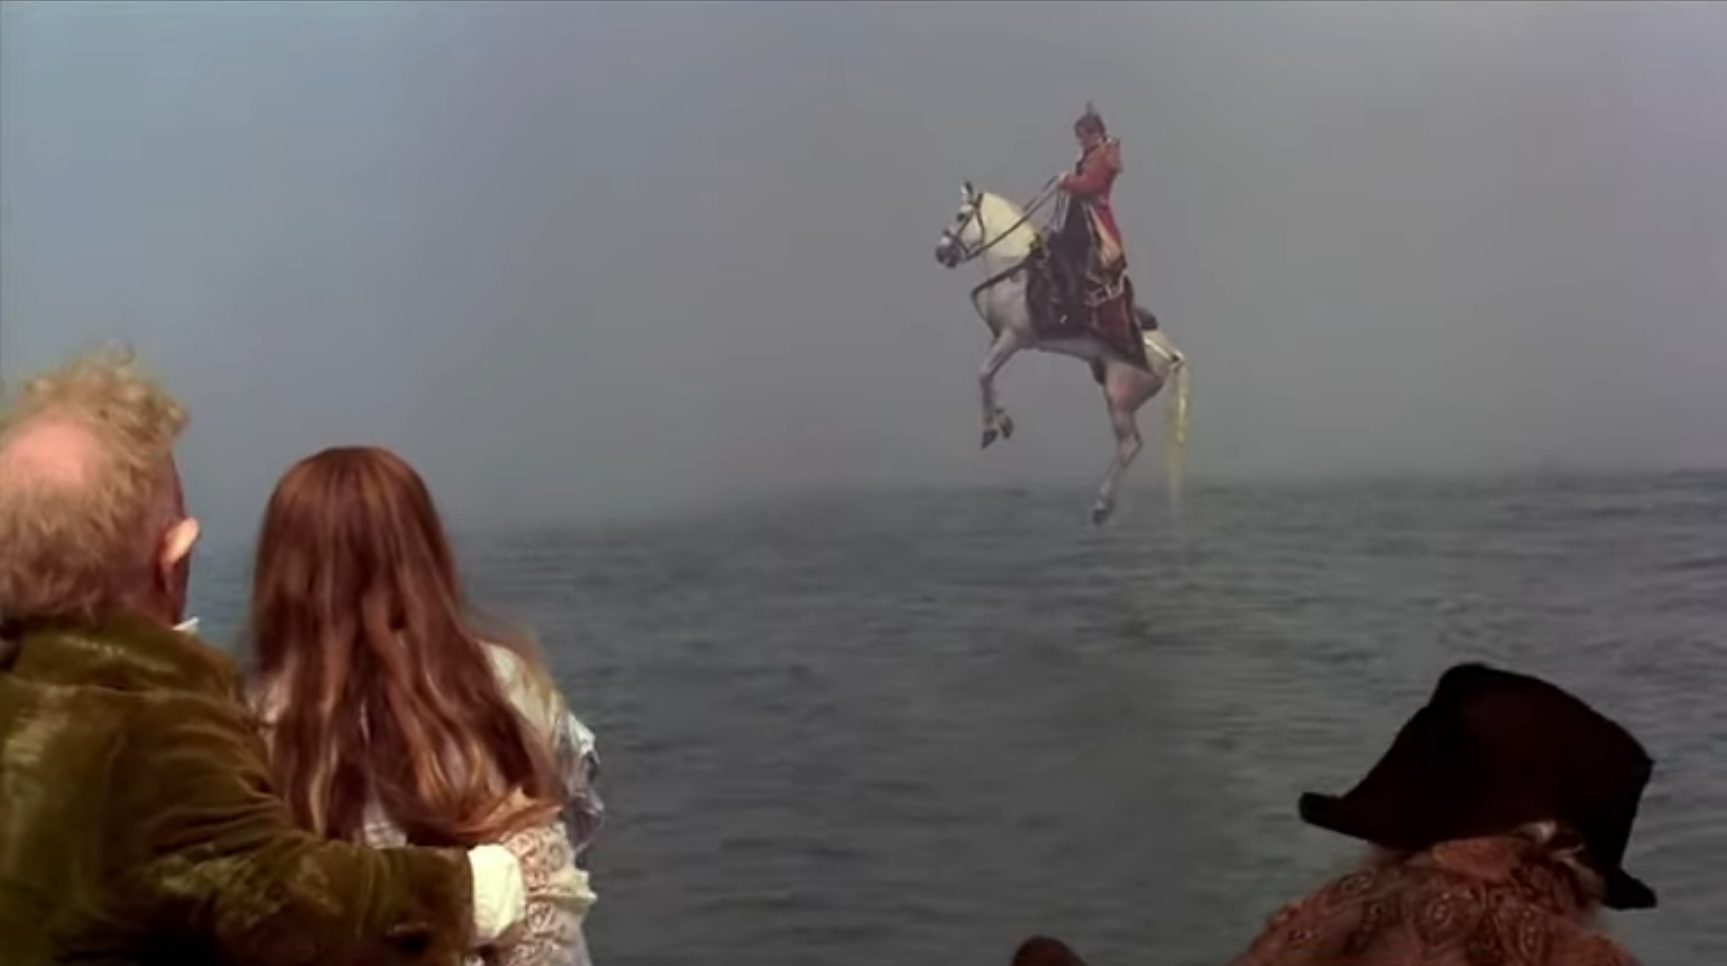
</div>

\- John Neville demonstrates, The Adventures of Baron Munchausen, Gilliam, 1988

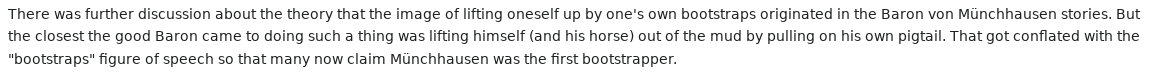
\- Lexicographer Ben Zimmer quoted in Boston Globe Ideas, Jan Freeman, 2009

## Further reading
References used for this workshop:
* Efron and Tibshirani, An Introduction to the Bootstrap
* Carpenter and Bithell, Statist.Med. 2000, https://www.tau.ac.il/~saharon/Boot/10.1.1.133.8405.pdf
* Hesterberg, Am Stat 2015 https://pubmed.ncbi.nlm.nih.gov/27019512/ (actually the more irreverent arXiv version https://arxiv.org/abs/1411.5279)

# Bonus content

## Inside stratification bonus
Say we don't trust stratification, let's make a function that looks inside:

In [53]:
effratenosy <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   print(paste(nrow(place),nrow(treat))) # report our group sizes
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate
 }


Running a tiny bootstrap, we see that with the balanced arms, each group has the same numbers. (If we randomly sampled across groups this would vary a bit.)

In [54]:
boot(vacctrial,effratenosy, 10, strata=vacctrial$group)

[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"



STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrial, statistic = effratenosy, R = 10, strata = vacctrial$group)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.9069767 -0.0006817579  0.03134603

Let's create a slightly imbalanced study:

In [55]:
smallarmB <- smallarm+1
vacctrialImb <- data.frame(outcome=c(rep(1,inf.plac),rep(0,smallarm-inf.plac),rep(1,inf.vacc),rep(0,smallarmB-inf.vacc)), group=c(rep(0,smallarm),rep(1,smallarmB)))
table(vacctrialImb)


       group
outcome   0   1
      0 914 993
      1  86   8

In [56]:
boot(vacctrialImb,effratenosy, 10, strata=vacctrialImb$group)

[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"



STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrialImb, statistic = effratenosy, R = 10, strata = vacctrialImb$group)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.9070697 0.01811728  0.02919545

## Timings bonus
It's not always clear what the most efficient route to calculation is going to be. The following are a few different ways of calculating the same statistic. They're all acceptably fast, but show a few things that may affect more complciated calculations

In [57]:
suppressPackageStartupMessages(library(data.table))

In [58]:
effratePlainR <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate
 }

effratePlainRLogic <- function(d,set) {
   samp <- d[set,]
   place <- samp$group==0
   treat <- samp$group==1
   placepos <- samp$group==0 & samp$outcome==1
   treatpos <- samp$group==1 & samp$outcome==1
   effrate <- 1 - (sum(treatpos)/sum(treat))/(sum(placepos)/sum(place))
   effrate
 }

effratePlainRLogicExtreme <- function(d,set) {
   place <- d$group[set]==0
   treat <- d$group[set]==1
   placepos <- d$group[set]==0 & d$outcome[set]==1
   treatpos <- d$group[set]==1 & d$outcome[set]==1
   effrate <- 1 - (sum(treatpos)/sum(treat))/(sum(placepos)/sum(place))
   effrate
 }

effrateByTable <- function(d,set) {
  thistable <- table(d[set,])
  effrate <- 1 - (thistable["1","1"]/sum(thistable[,"1"]))/(thistable["1","0"]/sum(thistable[,"0"]))
  effrate
}

effrateByDplyr <- function(d,set) {
    samp <- d[set,]
    place <- samp %>% filter(group==0)
    treat <- samp %>% filter(group==1)
    effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
    effrate
}

effrateByDplyrTable <- function(d,set) {
    # Need to do the factor stuff to stop empty levels disappearing in summarise
    thistable <- d[set,] %>% mutate(group=factor(group),outcome=factor(outcome)) %>%
        group_by(group,outcome, .drop=FALSE) %>% summarise(n=n(),.groups="drop_last")
    grptable <- thistable %>% summarise(n=sum(n),.groups="drop_last")
    effrate <- 1 - (filter(thistable,group==1,outcome==1)$n/filter(grptable,group==1)$n)/
        (filter(thistable,group==0,outcome==1)$n/filter(grptable,group==0)$n)
    effrate
}

effrateByDtable <- function(d,set) {
    samp <- as.data.table(d)[set,]
    place <- samp[group==0,]
    treat <- samp[group==1,]
    effrate <- 1 - (treat[,sum(outcome)]/nrow(treat))/(place[,sum(outcome)]/nrow(place))
    effrate
}

effrateOnDtable <- function(d,set) {
    samp <- d[set,]
    place <- samp[group==0,]
    treat <- samp[group==1,]
    effrate <- 1 - (treat[,sum(outcome)]/nrow(treat))/(place[,sum(outcome)]/nrow(place))
    effrate
}

effrateWeight <- function(d,set) {
   place <- d$group==0 * set
   treat <- d$group==1 * set
   placepos <- (d$group==0 & d$outcome==1) * set
   treatpos <- (d$group==1 & d$outcome==1) * set
   effrate <- 1 - (sum(treatpos)/sum(treat))/(sum(placepos)/sum(place))
   effrate * 100
 }

In [59]:
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainR, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainRLogic, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainRLogicExtreme, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByTable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDplyr, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDplyrTable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effrateByDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effrateOnDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effratePlainR, 1000, strata=vacctrial$group))

system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effrateWeight, 1000, strata=vacctrial$group, stype="w"))



   user  system elapsed 
  1.330   0.000   1.336 

   user  system elapsed 
  1.131   0.017   1.153 

   user  system elapsed 
  0.236   0.014   0.251 

   user  system elapsed 
  3.994   0.000   4.009 

   user  system elapsed 
  3.270   0.000   3.288 

   user  system elapsed 
 27.797   0.000  27.948 

   user  system elapsed 
  7.073   0.030   4.571 

   user  system elapsed 
  6.757   0.023   4.302 

   user  system elapsed 
  6.574   0.017   4.124 

   user  system elapsed 
  1.389   0.006   0.756 

   user  system elapsed 
  0.301   0.000   0.303 

First, all of these are acceptably fast to run with 10 or 20 thousand iterations. Problems are more likely to arise when bootstrapping hard-to-calculate statistics like mixed models.

Our inelegant plain-R approach is actually one of the fastest options, it minimises function calls and uses simple ones.

The logic operations approach is a little faster than the original one; there's less subsetting of data frames and creating new objects involved, but it's a little harder to read.

The extreme version of the logic operations approach is even faster, and even harder to read. By not doing `d[set,]` to explicitly create the new sample it saves time on creating a new data frame and only subsets basic vectors instead. However you might want to think twice about whether saving 15 seconds on a long bootstrap is worth the extra debugging time.

Table is a bit disappointing, this would be quite an elegant approach, probably it's doing extra work to handle more general cases.

Dplyr costs us a bit of time, although it might be a bit more readable. Attempting to use dplyr aggregation to take the table approach is about the same speed as the table approach.

data.table is often the fastest way to operate on filtering and joining data, but it seems to be slow here. (Overhead, internal conversion?). Trying to pre-convert the dataset to a data.table before the bootstrap, and even completely relying on having a data.table shows us this conversion is not the bottleneck.

Sending in a data.table to the original plain-R approach is actually a little slower (but not much).

The last example uses a different bootstrap approach, the weighted bootstrap. `set` now corresponds to weights for each observation, rather than indices to observations. We have to calculate in a different way, rather than using `set` to index the data, and this performs similarly to the logic operations. BCa calculation will also operate a little differently.

# A bigger boot
We cut down the sample size for the trial example because it takes a while to bootstrap and the default BCa with regression for influence will take a very long time and usually run out of memory. However it will work with the Jacknife influence values if we are willing to wait.

In [60]:
bigvacctrial <- data.frame(outcome=c(rep(1,inf.plac),rep(0,armsize-inf.plac),rep(1,inf.vacc),rep(0,armsize-inf.vacc)), group=c(rep(0,armsize),rep(1,armsize)))
table(bigvacctrial)

       group
outcome     0     1
      0 13914 13992
      1    86     8

In [61]:
system.time(
    boot.bigrisk.10000 <- boot(bigvacctrial,effratePlainRLogicExtreme, 10000, strata=bigvacctrial$group,
                               parallel = "multicore", ncpus = 2)
    )

   user  system elapsed 
 14.840   1.043  29.967 

We've used `effratePlainRLogicExtreme` here, because with the bigger data frame it really is a lot slower to create a new copy each time. Even `effratePlainRLogic` takes ten times as long.

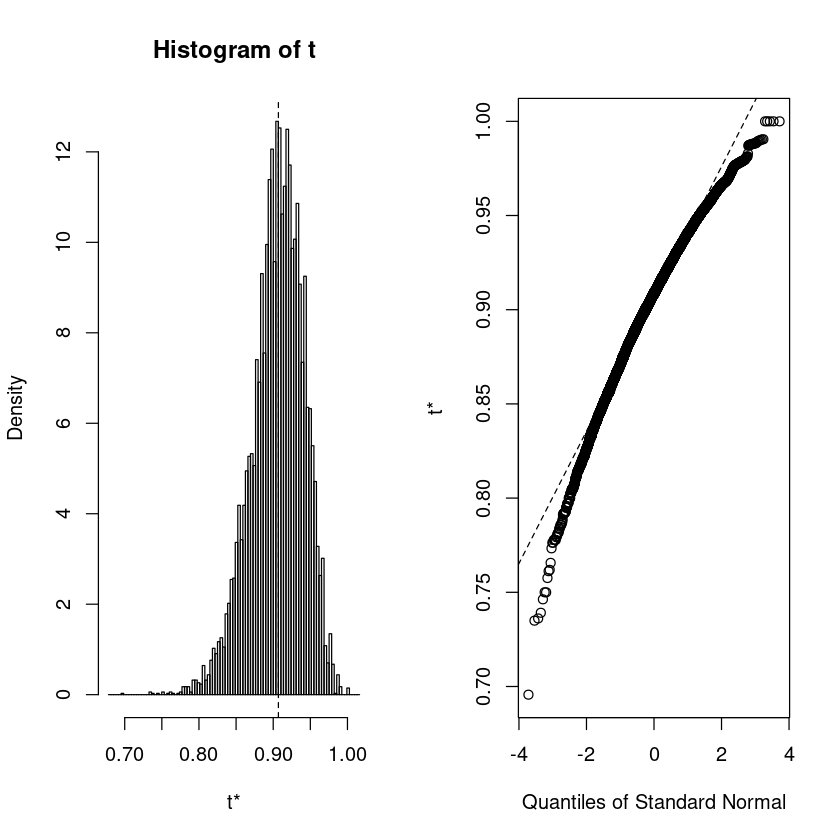

In [62]:
plot(boot.bigrisk.10000)

In [63]:
system.time(boot.bigrisk.10000.ci.jack <- boot.ci.jack(boot.bigrisk.10000))
boot.risk.10000.ci.jack$bca

   user  system elapsed 
 39.958   0.784  41.143 

conf,,,,
0.95,113.98,9556.01,81.81818,95.87629


In [64]:
rr.est.big.ci

[1] 80.81073 95.49054

Sadly empinf doesn't have an option to parallel calculate the jacknife, which is actually more calculations here than we have bootstrap replications.

## Studentised bootstrap
We previously ignored the studentised bootstrap, and should continue to do so. The studentised confidence interval is not as robust as the BCa or percentile intervals (although it has better coverage than Normal intervals), there's not much reason to use it.

However it does provide a nice exercise, as it needs a standard error estimate for each bootstrap sample. We could use it with analytic standard errors, but as usual, we often don't know them for a statistic we are trying to bootstrap.

Of course, we could always calculate the standard errors with a bootstrap. This gives a nested bootstrap, here's the outer function which uses our earlier diffR2se to bootstrap for the standard error calculation.

In [65]:
diffR2se <- function(thisdata, set, R=200){
    innerboot <- boot(thisdata[set,],diffR2,R=R)
    c(r2=innerboot$t0, r2se=sd(innerboot$t))
}

You can imaging this might take a while, 200 * 10000 bootstraps, if the original example took about 20 seconds, then this will be over an hour. (Actually, we have (10000 + 1) * (200 + 1) calculations of R^2, since each bootstrap also calculates t0 for the 'original' sample.)

In [66]:
#studentboot <- boot(mycleandata, diffR2se, 10000, parallel = "multicore", ncpus = 4)
studentboot<-readRDS("studentboot.rds") # Because the workshop isn't that long...

Our previous BCa result [0.101, 0.194]

In [67]:
studentboot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mycleandata, statistic = diffR2se, R = 10000, parallel = "multicore", 
    ncpus = 4)


Bootstrap Statistics :
      original        bias    std. error
t1* 0.13960048 -0.0001010909 0.023045906
t2* 0.02331584 -0.0007959714 0.003486338

In [68]:
studentboot.ci <- boot.ci(studentboot)
studentboot.ci

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = studentboot)

Intervals : 
Level      Normal              Basic             Studentized     
95%   ( 0.0945,  0.1849 )   ( 0.0918,  0.1820 )   ( 0.0958,  0.1897 )  

Level     Percentile            BCa          
95%   ( 0.0972,  0.1874 )   ( 0.1014,  0.1940 )  
Calculations and Intervals on Original Scale

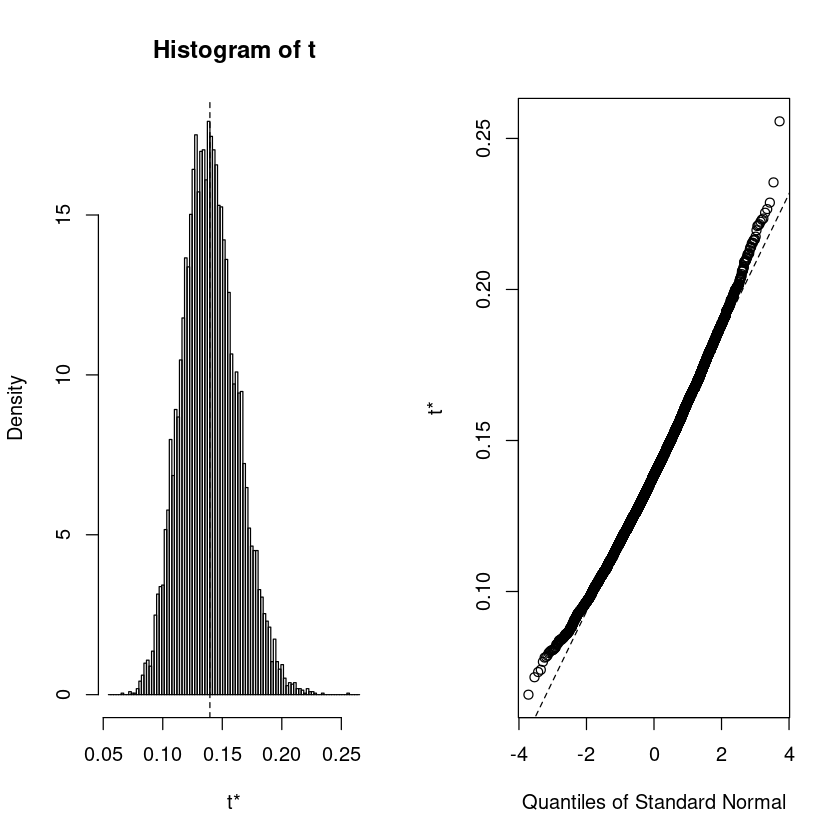

In [69]:
plot(studentboot,index=1)

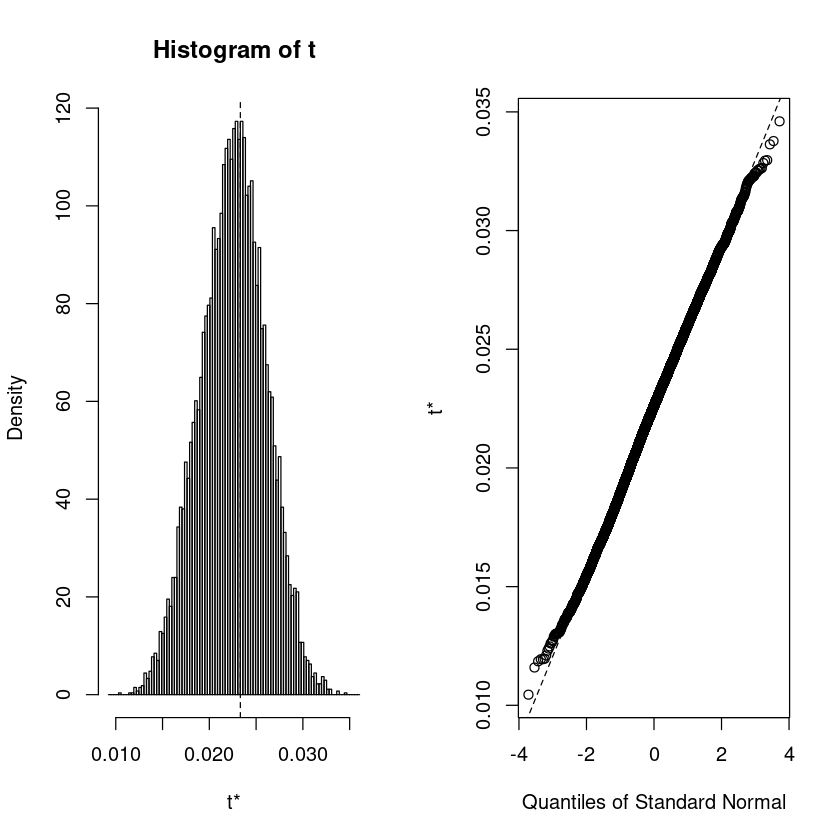

In [70]:
plot(studentboot,index=2)

In [71]:
library(ggplot2)

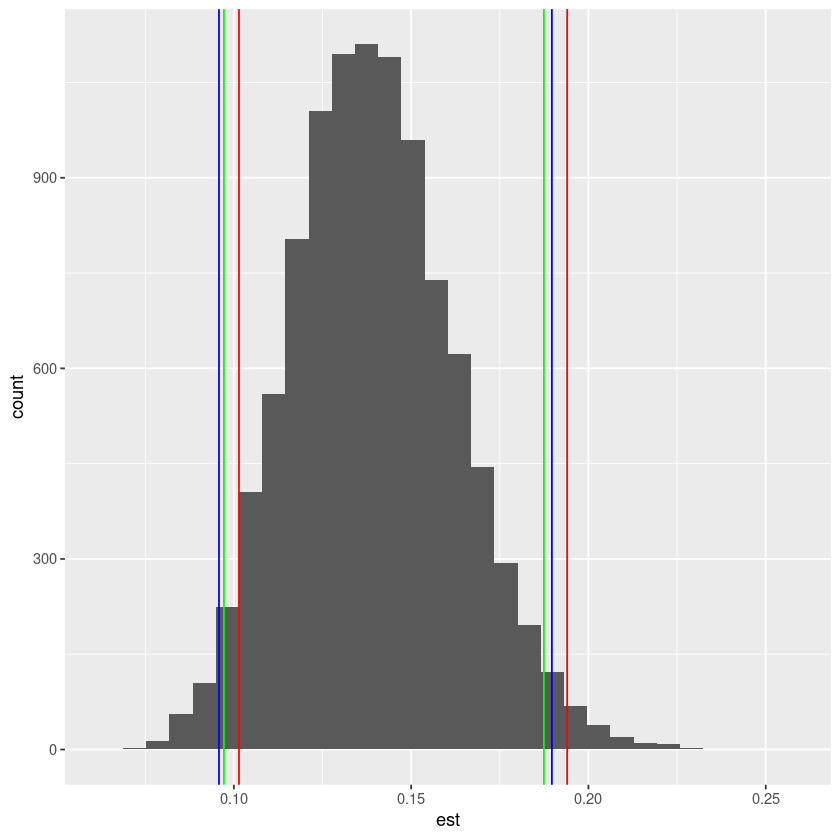

In [72]:
tees <- as.data.frame(studentboot$t)
names(tees) <- c("est","std.err")
ggplot(tees,aes(est)) + geom_histogram(bins=30) +  geom_vline(xintercept=studentboot.ci$bca[4:5], colour="red") +
 geom_vline(xintercept=studentboot.ci$student[4:5], colour="blue") +
 geom_vline(xintercept=studentboot.ci$perc[4:5], colour="green")

## Don't bootstrap at all!
Due to Tibshirani there is an analytical approximation to the BCa result (called ABC), but it requires a statistic that can use weights rather than resampling. This is simply done for the $R^2$ difference from the linear model:

In [73]:
diffR2weights <- function(thisdata,weights) {
    model.mwc <- lm(spm12_mwc ~ man, thisdata, weights=weights)
    model.fs5 <- lm(fs5 ~ man, thisdata, weights=weights)
    summary(model.mwc)$r.squared - summary(model.fs5)$r.squared
}

In [74]:
abc.ci(mycleandata,diffR2weights) # abc.ci is in the boot package

[1] 0.9500000 0.1013865 0.1948340

Compare our BCa result from bootstrapping:

In [75]:
bootstrap.diffR2.10000.clean.ci$bca[c(1,4,5)]

[1] 0.9500000 0.1017888 0.1956370

Much faster and gives a similar result. However we can't check what's going on behind the scenes, and doesn't report standard error (though we could ask for a different confidence interval). Also will only work for statistics that can be calculated in a weighted fashion.

## Packages

### bootstrap vs boot
The `bootstrap` package is also available in R, it implements the functions as described in 'An Introduction to the Bootstrap', `boot` is the recommended package for new users.

### tidymodels, rsample 
This implementation is meant to be more 'tidyverse' compliant, though it is less straightforward than boot unless you are doing something anticipated. For example, there is a tidy.lm method if you want your statistic to be derived from a linear model, but for the $R^2$ difference you need to create a result tibble of the right format yourself. Parallel processing requires knowing to swap out the map function for a parallel one from `furrr` (and performs a bit differently).

However, it carries out calculations a little differently from `boot`, which makes it a little slower in some cases, but faster for others. For the TIV $R^2$ difference it is slightly slower than `boot` to bootstrap, however in the vaccine example while it takes twice as long to bootstrap (single-threaded). It only knows about Jacknife influence estimates for calculating the BCa, so its default BCa calculations are sometimes faster than `boot`, however, boot can use Jacknife and infinitessimal Jacknife, so is more configurable. See `tidymodels-comparison.ipynb`.